In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
import torch
from torch import nn
import torch.nn.functional as F
from typing import Optional, Tuple
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa    
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from torchmetrics.regression import MeanSquaredError, MeanAbsolutePercentageError
#https://medium.com/intel-student-ambassadors/implementing-attention-models-in-pytorch-f947034b3e66from ray import train
from ray import train, tune
from ray.tune import ResultGrid
import pandas as pd
import skbio
from skbio import TreeNode
from io import StringIO
from ete3 import Tree
from skbio import diversity 
from skbio.diversity.beta import unweighted_unifrac, weighted_unifrac
from scipy.spatial.distance import braycurtis
import warnings
from collections import Counter
import concurrent.futures

from scipy.spatial import procrustes
warnings.filterwarnings("ignore")

2024-05-06 15:47:18,212	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-05-06 15:47:18,313	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
#https://towardsdatascience.com/regularisation-techniques-neural-networks-101-1f746ad45b72

In [3]:
torch.cuda.empty_cache()

communities = pd.read_csv('input_data/communities.csv')
enterosignatures = pd.read_csv('input_data/NMF_genus.csv', index_col = [0])
enterosignatures['dominant_ES'] = [enterosignatures.iloc[i].sort_values().index[-1] for i in range(len(enterosignatures))]
wu_M = pd.read_csv('wu_m.csv', index_col = [0])

In [4]:
pathways = pd.read_csv('input_data/controls_pathways.csv', index_col= [0]).iloc[:, 2:].sort_index()
taxonomy = pd.read_csv('input_data/controls_taxonomy.csv', index_col= [0]).sort_index()
metadata = pd.read_csv('input_data/controls_metadata.csv', index_col= [0]).sort_index()

metadata = metadata[metadata['age_category'] == 'adult']

In [5]:
def filter_prevalence(df, treshold = 0.05):
    '''features as columns'''
    df_binary = df.copy()
    df_binary[df_binary>0]=1
    df_binary_sum = df_binary.sum(axis=0)
    
    keep_features = df_binary_sum[df_binary_sum > df.shape[0]*treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df

def filter_on_abundance(df, abundance_treshold = 1e-3):
    '''features as columns'''
    df_relab = df.div(df.sum(axis=1), axis=0)
    df_relab_mean = df_relab.mean()

    keep_features = df_relab_mean[df_relab_mean > abundance_treshold].index
    filtered_df = df[keep_features]
    
    return filtered_df


pathways = filter_on_abundance(filter_prevalence(pathways, 0.1))
taxonomy = filter_on_abundance(filter_prevalence(taxonomy, 0.1))

In [6]:
pathways = pathways.rank(axis=1, method='dense')
taxonomy = taxonomy.rank(axis=1, method='dense')

In [7]:
HMP_samples = metadata[metadata.study_name == 'HMP_2019_ibdmdb'].sample_id.values

HMP_pathways = pathways.loc[HMP_samples]
HMP_taxonomy = taxonomy.loc[HMP_samples]

In [8]:
other_samples = metadata[metadata.study_name != 'HMP_2019_ibdmdb'].sample_id.values

other_pathways = pathways.loc[other_samples]
other_taxonomy = taxonomy.loc[other_samples]

In [9]:
taxonomy_input = taxonomy.sample(5000, random_state=42).copy()
pathways_input = pathways.sample(5000, random_state=42).copy()

In [10]:
taxonomy_input.shape, pathways_input.shape

((5000, 106), (5000, 204))

In [11]:
def apply_mask(input_data, mask_prob):
    mask = (torch.rand_like(input_data) > mask_prob).float()
    masked_input = input_data * mask
    return masked_input, mask

In [12]:
class Cross_attention_AE(nn.Module):
    def __init__(self, input_dim1, input_dim2, hl1=64, hl2=32, feature_dim=16, num_heads=2, dropout_rate=0.1, l1_reg=0.00):
        super(Cross_attention_AE, self).__init__()

        self.hl1 = hl1
        self.hl2 = hl2
        self.feature_dim = feature_dim
        self.l1_reg_value = l1_reg

        # Ensure the dimensions are suitable for multi-head attention
        assert hl1 % num_heads == 0, "hl1 must be divisible by num_heads for multi-head attention"

        self.dropout = nn.Dropout(p=dropout_rate)
        
        #Initial encoders for both inputs
        self.encoder_first_part1 = nn.Sequential(nn.Linear(input_dim1, hl1), nn.ReLU(), self.dropout)
        self.encoder_first_part2 = nn.Sequential(nn.Linear(input_dim2, hl1), nn.ReLU(), self.dropout)

        # Cross-modal attention layers
        self.cross_attention1_to_2 = nn.MultiheadAttention(embed_dim=hl1, num_heads=num_heads, batch_first=True)
        self.cross_attention2_to_1 = nn.MultiheadAttention(embed_dim=hl1, num_heads=num_heads, batch_first=True)

        # Shared encoder part after cross-attention
        self.encoder_second_part = nn.Sequential(
            nn.Linear(hl1*2, hl2),  # Features from both cross-attentions
            nn.ReLU(),
            nn.Linear(hl2, feature_dim),
        )

        # Decoders
        self.decoder1 = nn.Sequential(nn.Linear(feature_dim, hl2), nn.ReLU(), self.dropout, nn.Linear(hl2, hl1), nn.ReLU(), nn.Linear(hl1, input_dim1))
        self.decoder2 = nn.Sequential(nn.Linear(feature_dim, hl2), nn.ReLU(), self.dropout, nn.Linear(hl2, hl1), nn.ReLU(), nn.Linear(hl1, input_dim2))

        self.double()

    def forward(self, x1, x2, add_noise=False, noise_factor=0.1):
        
        if add_noise:
            
            noise1 = torch.randn_like(x1) * noise_factor
            noise2 = torch.randn_like(x2) * noise_factor
            
            x_noisy1 = x1 + noise1
            x_noisy2 = x2 + noise2
            
        else:
            x_noisy1 = x1
            x_noisy2 = x2
        
        x1_encoded = self.encoder_first_part1(x_noisy1).unsqueeze(1)  
        x2_encoded = self.encoder_first_part2(x_noisy2).unsqueeze(1)  

        # Cross-modal attention
        # x1 attending to x2
        cross_attended1, _ = self.cross_attention1_to_2(query=x1_encoded, key=x2_encoded, value=x2_encoded)
        cross_attended1 = cross_attended1.squeeze(1)

        # x2 attending to x1
        cross_attended2, _ = self.cross_attention2_to_1(query=x2_encoded, key=x1_encoded, value=x1_encoded)
        cross_attended2 = cross_attended2.squeeze(1)

        # Concatenate the cross-attended features
        concatenated_features = torch.cat((cross_attended1, cross_attended2), dim=1)
        
        # Pass through the shared encoder
        encoded = self.encoder_second_part(concatenated_features)

        # Decode
        reconstructed1 = self.decoder1(encoded)
        reconstructed2 = self.decoder2(encoded)
        
        return reconstructed1, reconstructed2

In [13]:
def prepare_data(df, test_size=0.2, random_state=42, scale=True):

    train_df, test_df = train_test_split(df, test_size=test_size, random_state=random_state)

    if scale == True:
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(train_df)
        X_test = scaler.transform(test_df)
    
    elif scale == False:
        X_train = train_df.copy()
        X_test = test_df.copy()
    
    train_tensor = torch.tensor(X_train, dtype=torch.float64)
    test_tensor = torch.tensor(X_test, dtype=torch.float64)
    
    train_dataset = torch.utils.data.TensorDataset(train_tensor, train_tensor)  
    test_dataset = torch.utils.data.TensorDataset(test_tensor, test_tensor)

    if scale == True:
        
        return scaler, train_dataset, test_dataset
    
    if scale == False:
        
        return [], train_dataset, test_dataset

In [14]:
def train_ae(config):
    
    checkpoint_dir = '.'
    model = Cross_attention_AE(input_dim1=taxonomy_input.shape[1], 
                                 input_dim2=pathways_input.shape[1],
                                 hl1=config["hl1"], 
                                 hl2=config['hl2'], 
                                 feature_dim=config["feature_dim"], 
                                 num_heads = config["num_heads"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
            
    model.to(device)
    
    # Assuming the reconstruction loss for both outputs is important
    criterion = nn.MSELoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    metric = MeanSquaredError()
    
    _, taxonomy_train_dataset, taxonomy_test_dataset = prepare_data(taxonomy_input)
    _, pathways_train_dataset, pathways_test_dataset = prepare_data(pathways_input)

    taxonomy_train_loader = torch.utils.data.DataLoader(taxonomy_train_dataset, batch_size=config['batch_size'], shuffle=True)
    taxonomy_test_loader = torch.utils.data.DataLoader(taxonomy_test_dataset, batch_size=config['batch_size'], shuffle=False)
    
    pathways_train_loader = torch.utils.data.DataLoader(pathways_train_dataset, batch_size=config['batch_size'], shuffle=True)
    pathways_test_loader = torch.utils.data.DataLoader(pathways_test_dataset, batch_size=config['batch_size'], shuffle=False)
    
    
    for epoch in range(100):
        
        model.train()
        running_loss = 0.0
        epoch_steps = 0.0
        t_MSE = 0.0
        p_MSE = 0.0
        
        for (t_data, t_target), (p_data, p_target)  in zip(taxonomy_train_loader, pathways_train_loader):
            
            t_data, t_target = t_data.to(device), t_target.to(device)
            p_data, p_target = p_data.to(device), p_target.to(p_target)
        
            masked_input1, mask1 = apply_mask(t_data, 0.15)
            masked_input2, mask2 = apply_mask(p_data, 0.15)
        
            optimizer.zero_grad()
        
            output1, output2 = model(masked_input1, masked_input2, add_noise=False)
            
            taxonomy_mse = metric(output1, t_target)
            pathways_mse = metric(output2, p_target)
            
            loss = criterion(output1, t_target) + criterion(output2, p_target)
            
            loss.backward()
            optimizer.step()
                
            running_loss += loss.item()
            t_MSE += taxonomy_mse.item()
            p_MSE += pathways_mse.item()
            epoch_steps += 1
            
            
        
        model.eval()
        test_loss = 0.0 
        test_steps = 0.0
        test_t_MSE = 0.0
        test_p_MSE = 0.0
        with torch.no_grad():
            
            for (t_data, t_target), (p_data, p_target)  in zip(taxonomy_test_loader, pathways_test_loader):
            
                dt_data, t_target = t_data.to(device), t_target.to(device)
                p_data, p_target = p_data.to(device), p_target.to(p_target)
            
                masked_input1, mask1 = apply_mask(t_data, 0.15)
                masked_input2, mask2 = apply_mask(p_data, 0.15)
                    
                output1, output2 = model(masked_input1, masked_input2, add_noise=False)

                taxonomy_mse = metric(output1, t_target)
                pathways_mse = metric(output2, p_target)
            
                loss = criterion(output1, t_target) + criterion(output2, p_target)
                
                test_loss += loss.item()
                test_t_MSE += taxonomy_mse.item()
                test_p_MSE += pathways_mse.item()
                test_steps += 1
                
        train.report({'loss':running_loss/epoch_steps, 
                      't_mse':t_MSE/epoch_steps,
                      'p_mse':p_MSE/epoch_steps,
                      'test_loss':test_loss/test_steps,
                     'test_t_mse':test_t_MSE/test_steps,
                      'test_p_mse':test_p_MSE/test_steps})
            
        print("Finished Training")

In [15]:
config = {
    "hl1": tune.choice([128, 64, 32, 16]),
    "hl2": tune.choice([128, 64, 32, 16]),
    "feature_dim": tune.choice([32, 16, 8, 4]),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([8, 16, 32, 64, 128]),
    "num_heads": tune.choice([1, 2, 4]),
    "l1_reg": tune.choice([0, 0.1, 0.25, 0.5, 0.7])
}

scheduler = ASHAScheduler(
    max_t=50,
    grace_period=10,
    reduction_factor=2,
    )

tuner = tune.Tuner(
    train_ae,
    param_space=config,
    run_config=train.RunConfig(
        name='test',
        stop={"training_iteration": 50},
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="loss",
            num_to_keep=5,
        ),
        storage_path=None,
    ),
    tune_config=tune.TuneConfig(mode="min", metric="test_loss", num_samples=50, scheduler=scheduler),
)
result_grid: ResultGrid = tuner.fit()

(raylet) Warning: The actor ImplicitFunc is very large (24 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.
(train_ae pid=7440) Finished Training
(train_ae pid=7441) Finished Training [repeated 20x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(train_ae pid=7444) Finished Training [repeated 28x across cluster]
(train_ae pid=7443) Finished Training [repeated 23x across cluster]
(train_ae pid=7444) Finished Training [repeated 24x across cluster]
(train_ae pid=7444) Finished Training [repeated 25x across cluster]
(train_ae pid=7447) Finished Training [repeated 24x across cluster]
(train_ae pid=7437) Finished Training [repeated 28x across cluster]
(train_ae pid=7444) Finished Training [repeated 3

2024-05-06 15:52:25,831	INFO tune.py:1004 -- Wrote the latest version of all result files and experiment state to '/Users/zkarwowska/ray_results/test' in 0.0316s.
2024-05-06 15:52:25,849	INFO tune.py:1036 -- Total run time: 302.19 seconds (301.90 seconds for the tuning loop).


In [16]:
best_checkpoint = result_grid.get_best_result(metric = 'test_loss')
best_params = best_checkpoint.config

In [17]:
best_checkpoint #NOW

Result(
  metrics={'loss': 0.7552208124706872, 't_mse': 0.49956359004974366, 'p_mse': 0.25565722095966337, 'test_loss': 0.7474479351778698, 'test_t_mse': 0.499424634501338, 'test_p_mse': 0.2480232990346849},
  path='/Users/zkarwowska/ray_results/test/train_ae_2ad22_00048_48_batch_size=32,feature_dim=16,hl1=64,hl2=128,l1_reg=0.7000,lr=0.0021,num_heads=4_2024-05-06_15-47-33',
  filesystem='local',
  checkpoint=None
)

In [80]:
t_scaler, taxonomy_train_dataset, taxonomy_test_dataset = prepare_data(taxonomy_input)
p_scaler, pathways_train_dataset, pathways_test_dataset = prepare_data(pathways_input)

model = Cross_attention_AE(input_dim1=taxonomy_input.shape[1], 
                             input_dim2=pathways_input.shape[1],
                             hl1=best_params["hl1"], 
                             hl2=best_params['hl2'], 
                             feature_dim=best_params["feature_dim"], 
                             num_heads = best_params["num_heads"])

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
        
model.to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'])
metric = MeanAbsolutePercentageError()

batch_size = best_params['batch_size']
taxonomy_train_loader = torch.utils.data.DataLoader(taxonomy_train_dataset, batch_size=batch_size, shuffle=False)
taxonomy_test_loader = torch.utils.data.DataLoader(taxonomy_test_dataset, batch_size=batch_size, shuffle=False)

pathways_train_loader = torch.utils.data.DataLoader(pathways_train_dataset, batch_size=batch_size, shuffle=False)
pathways_test_loader = torch.utils.data.DataLoader(pathways_test_dataset, batch_size=batch_size, shuffle=False)

results = []
for epoch in range(150):

    model.train()
    running_loss = 0.0
    epoch_steps = 0.0
    t_MSE = 0.0
    p_MSE = 0.0
    
    for (t_data, t_target), (p_data, p_target) in zip(taxonomy_train_loader, pathways_train_loader):
        
        t_data, t_target = t_data.to(device), t_target.to(device)
        p_data, p_target = p_data.to(device), p_target.to(p_target)
    
        masked_input1, mask1 = apply_mask(t_data, 0.15)
        masked_input2, mask2 = apply_mask(p_data, 0.15)
    
        optimizer.zero_grad()
    
        output1, output2 = model(masked_input1, masked_input2, add_noise=False)
        
        loss = criterion(output1, t_target)*2 +  criterion(output2, p_target)

        taxonomy_mse = metric(output1, t_target)
        pathways_mse = metric(output2, p_target)
        
        loss.backward()
        optimizer.step()
            
        running_loss += loss.item()
        t_MSE += taxonomy_mse.item()
        p_MSE += pathways_mse.item()
        epoch_steps += 1
        
            
    model.eval()
    test_loss = 0.0 
    test_steps = 0.0
    test_t_MSE = 0.0
    test_p_MSE = 0.0
    
    with torch.no_grad():
        
        for (t_data, t_target), (p_data, p_target) in zip(taxonomy_test_loader, pathways_test_loader):
        
            t_data, t_target = t_data.to(device), t_target.to(device)
            p_data, p_target = p_data.to(device), p_target.to(p_target)
        
            masked_input1, mask1 = apply_mask(t_data, 0.15)
            masked_input2, mask2 = apply_mask(p_data, 0.15)

            output1, output2 = model(masked_input1, masked_input2, add_noise=False)

            taxonomy_mse = metric(output1, t_target)
            pathways_mse = metric(output2, p_target)
        
            loss = criterion(output1, t_target)*2 + criterion(output2, p_target)

            test_loss += loss.item()
            test_t_MSE += taxonomy_mse.item()
            test_p_MSE += pathways_mse.item()
            test_steps += 1
    
    results.append({'epoch':epoch,
                    'loss':running_loss/epoch_steps,
                    't_MSE':t_MSE/epoch_steps,
                    'p_MSE':p_MSE/epoch_steps,
                    'test_loss':test_loss/test_steps,
                    'test_t_MSE':test_t_MSE/test_steps,
                    'test_p_MSE':test_p_MSE/test_steps})

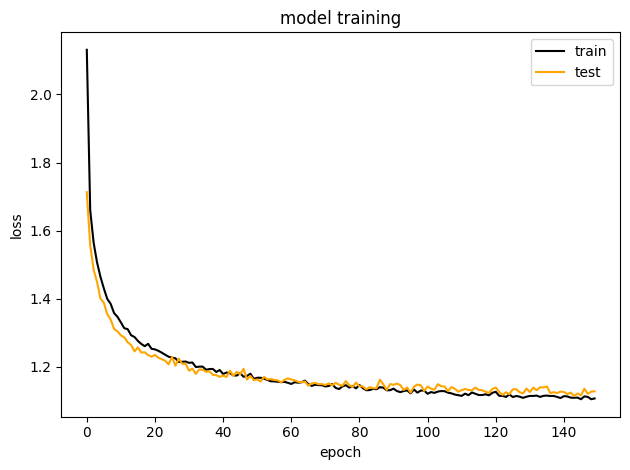

In [81]:
history = pd.DataFrame(results)

sns.lineplot(x = history.epoch, y = history.loss, color = 'k', label = 'train')
sns.lineplot(x = history.epoch, y = history.test_loss, color = 'orange', label = 'test')
plt.title('model training')
plt.tight_layout()
#plt.savefig('plots/vanillaAE/ranks/history.png', dpi=300)

### SHOW DATA ON VAL DATASET

In [82]:
taxonomy_val = HMP_taxonomy.copy() 
pathways_val = HMP_pathways.copy()

In [83]:
taxonomy_val_sc = t_scaler.transform(taxonomy_val)
taxonomy_val_sc_tensor = torch.tensor(taxonomy_val_sc, dtype=torch.float64)
taxonomy_val_masked, mask = apply_mask(taxonomy_val_sc_tensor, 0.15)

pathway_val_sc = p_scaler.transform(pathways_val)
pathway_val_sc_tensor = torch.tensor(pathway_val_sc, dtype=torch.float64)
pathway_val_masked, mask = apply_mask(pathway_val_sc_tensor, 0.15)

In [84]:
output1, output2 = model(taxonomy_val_masked, pathway_val_masked)

In [85]:
HMP_metadata = metadata[metadata.sample_id.isin(HMP_samples)]
subject_hue = HMP_metadata.subject_id.values

In [86]:
t_decoded = (t_scaler.inverse_transform(output1.detach().numpy()))
p_decoded = (p_scaler.inverse_transform(output2.detach().numpy()))

t_decoded[t_decoded<0]=0
p_decoded[p_decoded<0]=0

p_decoded_df = pd.DataFrame(p_decoded, columns = pathways_val.columns)
t_decoded_df = pd.DataFrame(t_decoded, columns = taxonomy_val.columns)

p_decoded_df.index = pathways_val.index
t_decoded_df.index = taxonomy_val.index

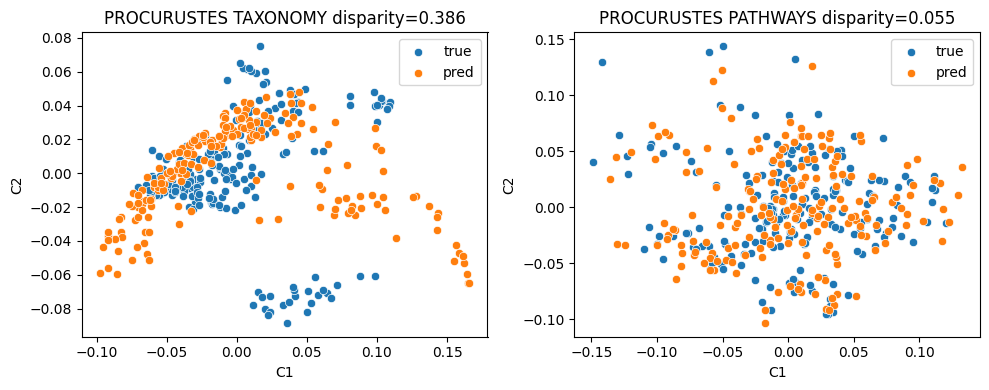

In [87]:
t_decoded_pcoa = pcoa(squareform(pdist((t_decoded_df), 'braycurtis'))).samples.iloc[:, :2]
t_true_pcoa = pcoa(squareform(pdist((taxonomy_val), 'braycurtis'))).samples.iloc[:, :2]
p_decoded_pcoa = pcoa(squareform(pdist((p_decoded_df), 'braycurtis'))).samples.iloc[:, :2]
p_true_pcoa = pcoa(squareform(pdist((pathways_val), 'braycurtis'))).samples.iloc[:, :2]

Tmtx1, Tmtx2, Tdisp = procrustes(t_decoded_pcoa, t_true_pcoa)
Pmtx1, Pmtx2, Pdisp = procrustes(p_decoded_pcoa, p_true_pcoa)

fig, axes = plt.subplots(1, 2, figsize = (10, 4))

sns.scatterplot(x = Tmtx2[:, 0], y = Tmtx2[:, 1], ax=axes[0], label = 'true')
sns.scatterplot(x = Tmtx1[:, 0], y = Tmtx1[:, 1], ax=axes[0], label = 'pred')

sns.scatterplot(x = Pmtx2[:, 0], y = Pmtx2[:, 1], ax=axes[1], label = 'true')
sns.scatterplot(x = Pmtx1[:, 0], y = Pmtx1[:, 1], ax=axes[1], label = 'pred')

axes[0].set_xlabel('C1')
axes[0].set_ylabel('C2')

axes[1].set_xlabel('C1')
axes[1].set_ylabel('C2')

plt.tight_layout()

axes[0].set_title(f'PROCURUSTES TAXONOMY disparity={np.round(Tdisp, 3)}')
axes[1].set_title(f'PROCURUSTES PATHWAYS disparity={np.round(Pdisp, 3)}')

plt.tight_layout()
#plt.savefig('plots/vanillaAE/ranks/braycurtis_procrustes_taxonomy_pathways.png', dpi=300)

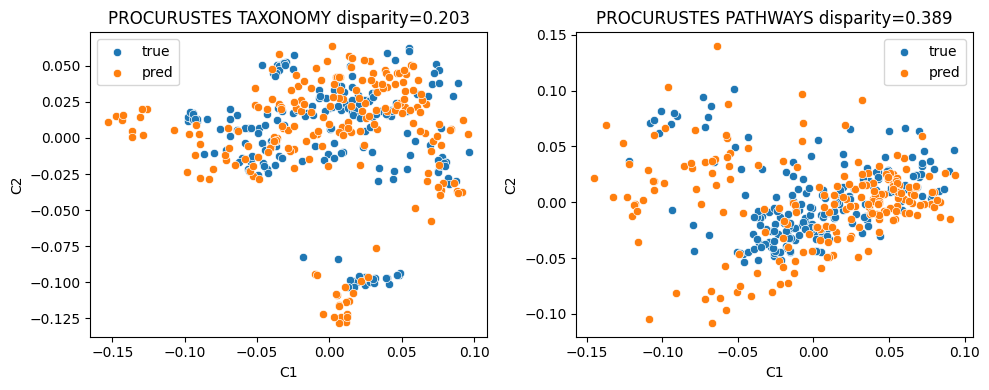

In [88]:
t_decoded_pcoa = pcoa(squareform(pdist(np.log(t_decoded_df+1e-2), 'euclidean'))).samples.iloc[:, :2]
t_true_pcoa = pcoa(squareform(pdist(np.log(taxonomy_val+1e-2), 'euclidean'))).samples.iloc[:, :2]
p_decoded_pcoa = pcoa(squareform(pdist(np.log(p_decoded_df+1e-2), 'euclidean'))).samples.iloc[:, :2]
p_true_pcoa = pcoa(squareform(pdist(np.log(pathways_val+1e-2), 'euclidean'))).samples.iloc[:, :2]

Tmtx1, Tmtx2, Tdisp = procrustes(t_decoded_pcoa, t_true_pcoa)
Pmtx1, Pmtx2, Pdisp = procrustes(p_decoded_pcoa, p_true_pcoa)

fig, axes = plt.subplots(1, 2, figsize = (10, 4))

sns.scatterplot(x = Tmtx2[:, 0], y = Tmtx2[:, 1], ax=axes[0], label = 'true')
sns.scatterplot(x = Tmtx1[:, 0], y = Tmtx1[:, 1], ax=axes[0], label = 'pred')

sns.scatterplot(x = Pmtx2[:, 0], y = Pmtx2[:, 1], ax=axes[1], label = 'true')
sns.scatterplot(x = Pmtx1[:, 0], y = Pmtx1[:, 1], ax=axes[1], label = 'pred')

axes[0].set_xlabel('C1')
axes[0].set_ylabel('C2')

axes[1].set_xlabel('C1')
axes[1].set_ylabel('C2')

plt.tight_layout()

axes[0].set_title(f'PROCURUSTES TAXONOMY disparity={np.round(Tdisp, 3)}')
axes[1].set_title(f'PROCURUSTES PATHWAYS disparity={np.round(Pdisp, 3)}')

plt.tight_layout()
#plt.savefig('plots/vanillaAE/ranks/euclidean_procrustes_taxonomy_pathways.png', dpi=300)

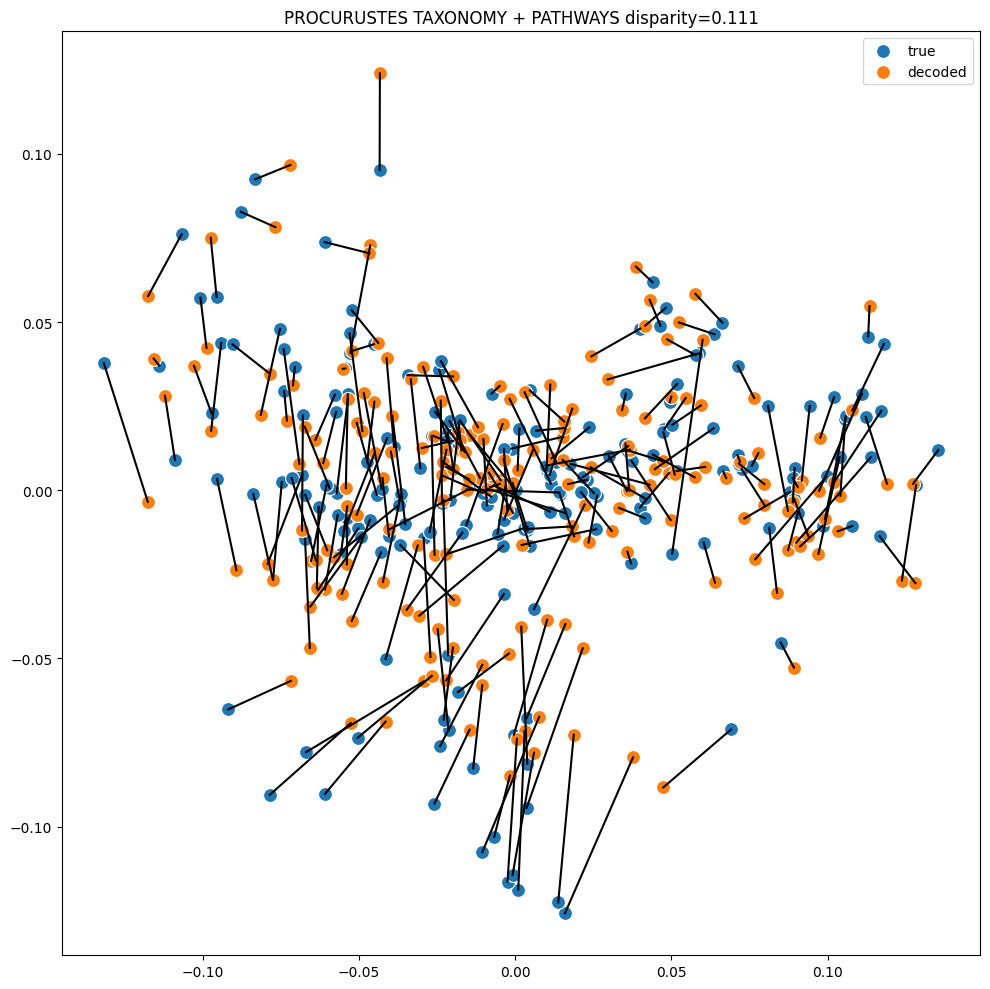

In [89]:
decoded_df = pd.concat([t_decoded_df, p_decoded_df],axis=1)
decoded_relab = decoded_df.div(decoded_df.sum(axis=1), axis=0)
true_df = pd.concat([taxonomy_val, pathways_val],axis=1)
true_relab = true_df.div(true_df.sum(axis=1), axis=0)

decoded_pcoa = pcoa(squareform(pdist(np.log(decoded_relab+1e-2), 'euclidean'))).samples.iloc[:, :2]
true_pcoa = pcoa(squareform(pdist(np.log(true_relab+1e-2), 'euclidean'))).samples.iloc[:, :2]

A, B, disp = procrustes(true_pcoa, decoded_pcoa)

plt.figure(figsize = (10, 10))
sns.scatterplot(x = A[:, 0], y = A[:, 1], label = 'true', s=100)
sns.scatterplot(x = B[:, 0], y = B[:, 1], label = 'decoded', s=100)

for i in range(len(A)):
    plt.plot([A[i][0], B[i][0]], [A[i][1], B[i][1]], 'black', linestyle='-')  # Connect with dashed gray lines

plt.title(f'PROCURUSTES TAXONOMY + PATHWAYS disparity={np.round(disp, 3)}')
plt.tight_layout()
#plt.savefig('plots/vanillaAE/ranks/procrustes.png', dpi=300)

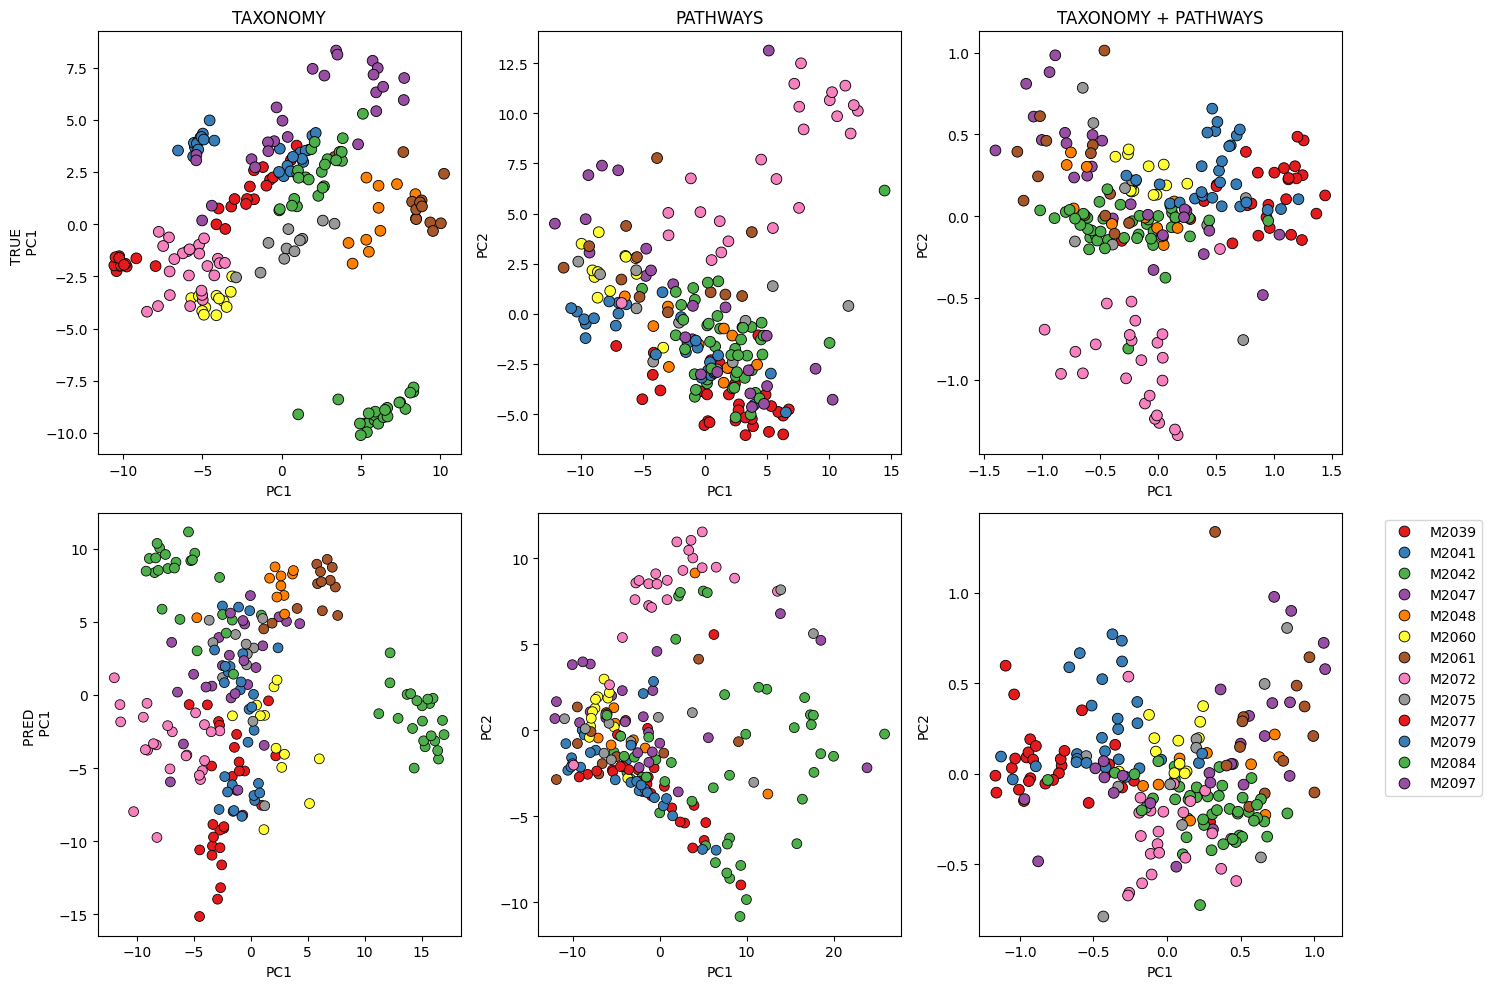

In [60]:
fig, axes = plt.subplots(2, 3, figsize = (15, 10))

sns.scatterplot(x = t_true_pcoa.PC1, y=t_true_pcoa.PC2, hue = subject_hue, palette = 'Set1', s=60, ax=axes[0, 0], legend=False, edgecolor='k')
sns.scatterplot(x = p_true_pcoa.PC1, y=p_true_pcoa.PC2, hue = subject_hue, palette = 'Set1', s=60, ax=axes[0, 1], legend=False, edgecolor='k')
sns.scatterplot(x = true_pcoa.PC1, y=true_pcoa.PC2, hue = subject_hue, palette = 'Set1', s=60, ax=axes[0, 2], legend=False, edgecolor='k')

sns.scatterplot(x = t_decoded_pcoa.PC1, y=t_decoded_pcoa.PC2, hue = subject_hue, palette = 'Set1', s=50, ax=axes[1, 0], legend=False, edgecolor='k')
sns.scatterplot(x = p_decoded_pcoa.PC1, y=p_decoded_pcoa.PC2, hue = subject_hue, palette = 'Set1', s=50, ax=axes[1, 1], legend=False, edgecolor='k')
sns.scatterplot(x = decoded_pcoa.PC1, y=decoded_pcoa.PC2, hue = subject_hue, palette = 'Set1', s=60, ax=axes[1, 2], edgecolor='k')

axes[0, 0].set_ylabel(f'TRUE \n PC1')
axes[1, 0].set_ylabel(f'PRED \n PC1')

axes[0, 0].set_title(f'TAXONOMY')
axes[0, 1].set_title(f'PATHWAYS')
axes[0, 2].set_title(f'TAXONOMY + PATHWAYS')

plt.legend(bbox_to_anchor = (1.1, 1))
plt.tight_layout()
#plt.savefig('plots/vanillaAE/ranks/pcoa.png', dpi=300)

## LATENT

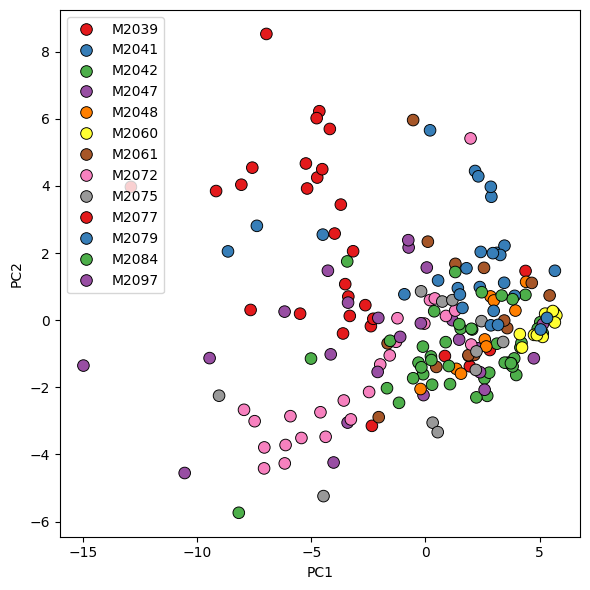

In [61]:
#HMP_data.subject_id.tolist()

# LATENT
l1 = model.encoder_first_part1(taxonomy_val_sc_tensor)
l2 = model.encoder_first_part2(pathway_val_sc_tensor)

concatenated_features = torch.cat((l1, l2), dim=1)
encoded = model.encoder_second_part(concatenated_features)

pcoa_df = pcoa(squareform(pdist(encoded.detach().numpy(), 'euclidean'))).samples.iloc[:, :3]

plt.figure(figsize = (6, 6))
sns.scatterplot(x = pcoa_df['PC1'], y = pcoa_df['PC2'], hue = subject_hue.tolist(), legend=True, edgecolor='k', s=70,  palette = 'Set1')
plt.tight_layout()
#plt.savefig('plots/vanillaAE/ranks/latent.png', dpi=300)

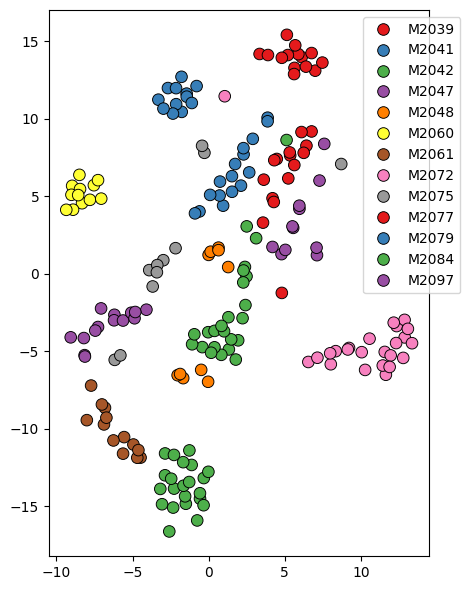

In [62]:
from sklearn.manifold import TSNE


tsne = TSNE()
tsne_embedding = tsne.fit_transform(true_relab)

plt.figure(figsize = (6, 6))
sns.scatterplot(x = tsne_embedding[:, 0], y = tsne_embedding[:, 1], hue = subject_hue.tolist(), legend=True, edgecolor='k', s=70,  palette = 'Set1')
plt.legend(bbox_to_anchor = (1.1, 1))
plt.tight_layout()
#plt.savefig('plots/vanillaAE/ranks/latent_tsne.png', dpi=300)

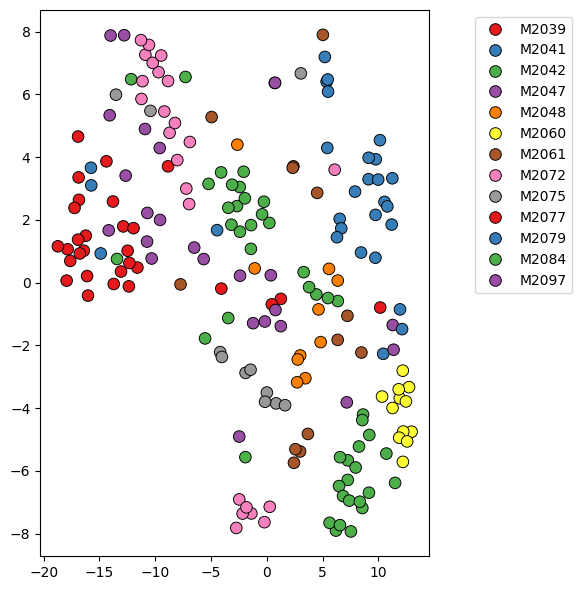

In [63]:
tsne = TSNE()
tsne_embedding = tsne.fit_transform(encoded.detach().numpy())

plt.figure(figsize = (6, 6))
sns.scatterplot(x = tsne_embedding[:, 0], y = tsne_embedding[:, 1], hue = subject_hue.tolist(), legend=True, edgecolor='k', s=70,  palette = 'Set1')
plt.legend(bbox_to_anchor = (1.1, 1))
plt.tight_layout()
#plt.savefig('plots/vanillaAE/ranks/latent_tsne.png', dpi=300)

Text(0.5, 1.0, 'TAXONOMY')

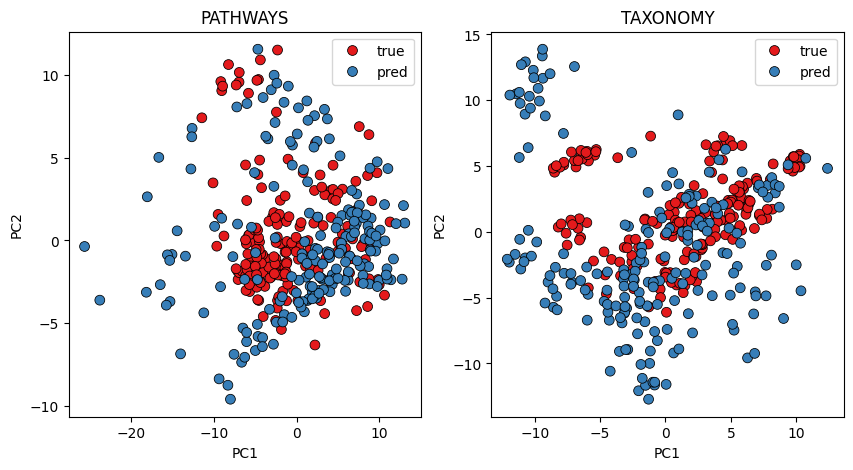

In [64]:
pathways_val['data'] = 'true'
p_decoded_df['data'] = 'pred'

pathways_df = pd.concat([pathways_val, p_decoded_df], axis=0)
pathways_pcoa = pcoa(squareform(pdist(np.log(pathways_df.set_index('data')+1e-2), 'euclidean'))).samples

taxonomy_val['data'] = 'true'
t_decoded_df['data'] = 'pred'

taxonomy_df = pd.concat([taxonomy_val, t_decoded_df], axis=0)
taxonomy_pcoa = pcoa(squareform(pdist(np.log(taxonomy_df.set_index('data')+1e-2), 'euclidean'))).samples

fig, axes = plt.subplots(1, 2, figsize = (10, 5))
sns.scatterplot(x = pathways_pcoa.PC1, y=pathways_pcoa.PC2, hue = pathways_df.data.values, palette = 'Set1', s=50, legend=True, edgecolor='k', ax=axes[0])
sns.scatterplot(x = taxonomy_pcoa.PC1, y=taxonomy_pcoa.PC2, hue = pathways_df.data.values, palette = 'Set1', s=50, legend=True, edgecolor='k', ax=axes[1])

axes[0].set_title('PATHWAYS')
axes[1].set_title('TAXONOMY')

#plt.savefig('plots/vanillaAE/ranks/euclidean_pathways.png', dpi=300)

In [65]:
# Prepare tree for unifrac analysis
nwk = 'input_data/tree.nwk'

ete3_tree = Tree(newick = nwk)
skbio_tree = TreeNode.read(nwk, 'newick')
leaf_names = ete3_tree.get_leaf_names()

otu_ids = taxonomy_input.columns.tolist()

#prune tree to only bacteria present in counts table
ete3_tree.prune(otu_ids, True)
pruned_skbio_tree = TreeNode.read(StringIO(ete3_tree.write(format=1, format_root_node=True)))

def replace_spaces_in_names_skbio(node):
    # Replace spaces with double underscores in the current node's name if it has one
    if node.name:
        node.name = node.name.replace(' ', '_')
    # Recursively apply this to all children
    for child in node.children:
        replace_spaces_in_names_skbio(child)

# Apply the function to your tree
replace_spaces_in_names_skbio(pruned_skbio_tree)

In [66]:
wUW_taxonomy = taxonomy_df.iloc[:, :-1]

In [67]:
import numpy as np
from joblib import Parallel, delayed

num_samples = wUW_taxonomy.shape[0]

# Function to calculate distance for one pair
def calculate_distance(i, j):
    if j > i:  # Ensures we calculate only for the upper triangle
        distance = weighted_unifrac(wUW_taxonomy.iloc[i], wUW_taxonomy.iloc[j], otu_ids, pruned_skbio_tree)
        return i, j, distance
    return i, j, 0

# Initialize an empty matrix to store the distances
distance_matrix = np.zeros((num_samples, num_samples))

# Parallel computation of distances
results = Parallel(n_jobs=-1, verbose=10)(delayed(calculate_distance)(i, j) for i in range(num_samples) for j in range(i, num_samples))

# Fill the distance matrix using results
for i, j, distance in results:
    distance_matrix[i, j] = distance
    if i != j:  # Mirror the distance since the matrix is symmetric
        distance_matrix[j, i] = distance

wu_M = pd.DataFrame(distance_matrix, columns = wUW_taxonomy.index)
wu_M.index =  wUW_taxonomy.index

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.18328753988744387s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.03830385208129883s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.04073500633239746s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    3.3s
[Parallel(n_job

<Axes: xlabel='PC1', ylabel='PC2'>

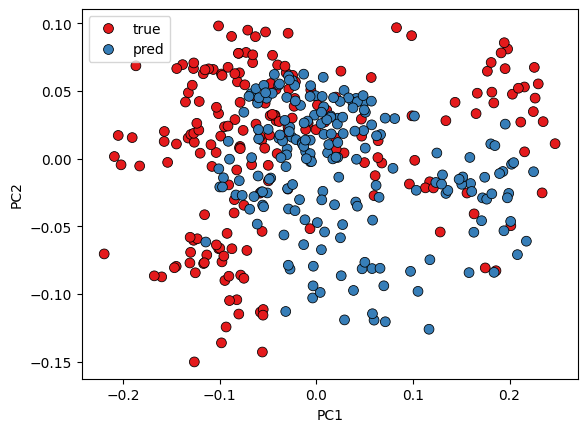

In [69]:
unifrac_pcoa = pcoa(wu_M).samples
sns.scatterplot(x = unifrac_pcoa.PC1, y=unifrac_pcoa.PC2, hue = taxonomy_df.data.values, palette = 'Set1', s=50, legend=True, edgecolor='k')
#plt.savefig('plots/vanillaAE/ranks/unifrac_pcoa.png', dpi=300)